In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/MPdBP/MatrixProductBP`


In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics
using Base.Threads
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [20]:
function infected_bp_bondsize(T::Integer, N::Integer, k::Integer, λ::Real, κ::Real, γ::Real, nobs::Integer,
        bonddims::AbstractVector{Int}; kw...)
    
    auc_bp = [zeros(0) for _ in bonddims]
    
    # random (?) tree
    gg = random_regular_graph(N, k)
    t = SimpleGraph(prim_mst(gg))
    g = IndexedGraph(t)
    
    # make sure the mst is connected
    while !is_connected(g)
        gg = random_regular_graph(N, k)
        t = SimpleGraph(prim_mst(gg))
        g = IndexedGraph(t)
    end
    p⁰ = fill([1-γ, γ], N)
    sis = SIS(g, λ, κ, T; p⁰) 
    bp = mpbp(sis)
    # observe at final time
    x = draw_node_observations!(bp, nobs, last_time=true, softinf=1e1)
    # see who are the zero patients
    true_infected = [findall(isequal(INFECTED), x[:,t]) for t in 1:T+1]  
    
    for j in eachindex(bonddims)
        svd_trunc = TruncBond(bonddims[j])
        reset_messages!(bp)
        guess_bp = find_infected_bp(bp; svd_trunc, kw...)
        auc_bp[j] = auc.(guess_bp, true_infected)
    end
    auc_bp
end

infected_bp_bondsize (generic function with 1 method)

In [37]:
T = 10
N = 20
k = 3
λ = 0.2
κ = 0.15
γ = 0.2
nobs = N÷2
bonddims = [2, 3, 6];

In [38]:
aucs_bp = Vector{Vector{Float64}}[];

In [39]:
ninstances = 100
aucs_bp_ = [[zeros(T+1) for _ in bonddims] for _ in 1:ninstances]
@threads for n in 1:ninstances
    aucs_bp_[n] = infected_bp_bondsize(T, N, k, λ, κ, γ, nobs, bonddims)
end
append!(aucs_bp, aucs_bp_);

In [40]:
aucs_bp_avg = map(eachindex(bonddims)) do i
    mean([a[i] for a in aucs_bp])
end
aucs_bp_std = map(eachindex(bonddims)) do i
    std([a[i] for a in aucs_bp]) ./ sqrt(length(aucs_bp))
end; 

SIS with: P(S→I)=λ=0.2, P(I→S)=κ=0.15. P(zero patient)=γ=0.2
Random regular N=20, k=3. T=10, 10 random observations from the prior at final time
Average over 100 random instances


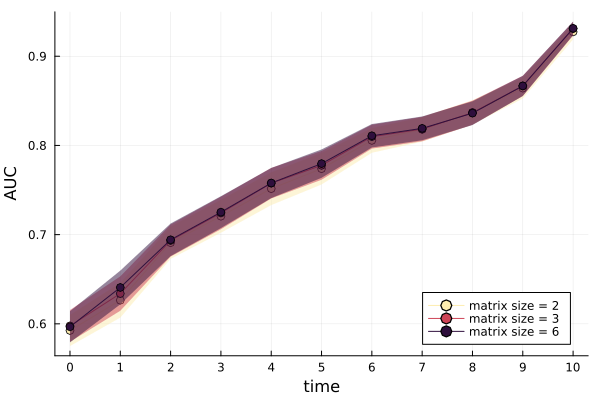

In [41]:
println("SIS with: P(S→I)=λ=$λ, P(I→S)=κ=$κ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=$k. T=$T, $nobs random observations from the prior at final time")
println("Average over ", length(aucs_bp), " random instances")
using ColorSchemes
cg = cgrad(:matter, length(bonddims), categorical=true)
pl = plot(xlabel="time", ylabel="AUC", xticks=0:T, legend=:bottomright)
for i in eachindex(bonddims)
    plot!(pl, 0:T, aucs_bp_avg[i], ribbon=aucs_bp_std[i], c=cg[i],
        label="matrix size = $(bonddims[i])", m=:o)
end
pl